# Seznam vidnih astronomskih objektov

Program izdela seznam vseh vidnih navigacijskih astronoskih objektov z njihovimi karakterističnimi podatki.

Vhodni podatki so:
- **položaj**
- **čas meritve**

Položaje vnašamo v obliki, kot je v navtiki dogovor 

$\varphi = \#\#^\circ \, \#\#.\#' \, \mathrm{N/S}$, $\lambda = \#\#\#^\circ \, \#\#.\#' \, \mathrm{E/W}$, 

kjer imamo stopinje kot celo število in minute kot število na 1 decimalno mesto natančno.

Format vnosa položaja:
- LAT-$\varphi$ in LONG-$\lambda$ vnašamo v formatu [stopinje, minute, stran neba]

Primer vnosa položaja:
- $\varphi$: [12, 34.5, 'N']
- $\lambda$: [117, 12.6, 'W']
- stran neba mora biti v **enojnih navednicah**, kjer so dovoljeni znaki 'N', 'S', 'E', 'W'

Čas meritve zapišemo v obliki
- datum: *date*=[day,month,year]
- ura: *time*=[hour,minutes, seconds]

Izhodni podatki:
- **ime objekta**
- **računana višina** - $h$
- **računani azimut** - $\omega$
- **deklinacija** - $\delta$
- **grenvični časovni kot** - Gha (za zvezdo je vsota med Gha pomladišča in Sha)
- **siderični časovni kot** - Sha (samo zvezde)

In [1]:
import os, sys
import subprocess as sp

# add custom modules and astro data path 
pp = '../nav_tools/'
sys.path.append(pp)

In [2]:
import numpy as np
import matplotlib.pyplot as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams.update({'font.size': 7})

import celestialdata as cdata
import navigationalstars as ns
import navtools as nt

In [3]:
def findVisibleObjects(obj_data, h_min, h_max):
        
    vs = []
    for obj in obj_data:
        if obj['hc'] >= h_min and obj['hc'] <= h_max:
            vs.append({'name':obj['name'], 'alt':obj['hc'], 'az':obj['wc'], 'dec':obj['dec'], 'gha':obj['gha'], 'sha':obj['sha'], 'lha':obj['lha']})
    
    return vs

In [4]:
def generateLatexInput(date,time,pos,stars,gha_a,obs_h,h0,h1):
    
    fo = open('body.tex','w')
    
    str_fi = r"$\varphi={:02d}^\circ \, {:04.1f}' \, \mathrm{{{:s}}}$".format(pos[0][0],pos[0][1],pos[0][2])
    str_la = r"$\lambda={:03d}^\circ \, {:04.1f}' \, \mathrm{{{:s}}}$".format(pos[1][0],pos[1][1],pos[1][2])
    
    fo.write(r'\textbf{{Position}}: {:s}, {:s}\\[2mm]'.format(str_fi, str_la)); fo.write('\n')
    fo.write(r'\textbf{{Date}} ({{\footnotesize yyyy/mm/dd}}): {:04d}/{:02d}/{:02d}\\[2mm]'.format(date[0],date[1],date[2])); fo.write('\n')
    fo.write(r'\textbf{{Time}}: {:02d}:{:02d}:{:02d} UTC\\[2mm]'.format(time[0],time[1],time[2])); fo.write('\n')
    
    gha_a_dm = nt.dd2dms(gha_a)
    str_gha_a = r"${:02d}^\circ \, {:04.1f}'$".format(int(gha_a_dm[0]), gha_a_dm[1])
    fo.write(r'$\textbf{{\textsc{{Gha}}}}_{{\aries}}:$ {:s}\\[2mm]'.format(str_gha_a)); fo.write('\n')
    fo.write(r'\textbf{{Altitude limit}}: $h_{{\mathrm{{min}}}}={:02d}^\circ$; $h_{{\mathrm{{\max}}}}={:02d}^\circ$\\'.format(int(h0),int(h1))); fo.write('\n')
    
    fo.write(r'\begin{center}'); fo.write('\n')
    fo.write(r'   \includegraphics[width=16cm]{visible_stars.pdf}'); fo.write('\n')
    fo.write(r'\end{center}'); fo.write('\n')
    
    fo.write(r'\vspace{5mm}'); fo.write('\n')
    fo.write(r'\begin{center}'); fo.write('\n')
    fo.write(r'\footnotesize'); fo.write('\n')
    fo.write(r'\begin{tabular}{l l r r r r r r}\hline'); fo.write('\n')
    fo.write(r' \multicolumn{1}{c}{\#} & \multicolumn{1}{c}{Name} & \multicolumn{1}{c}{$h$} & \multicolumn{1}{c}{$\omega$} & \multicolumn{1}{c}{$\delta$} & \multicolumn{1}{c}{\textsc{Gha}} & \multicolumn{1}{c}{\textsc{Sha}} & \multicolumn{1}{c}{\textsc{Lha}}\\ \hline'); fo.write('\n')
    
    i = 1
    for star in stars:
        h_dm = nt.dd2dms(star['alt'])
        str_h = r"${:02d}^\circ \, {:04.1f}'$".format(int(h_dm[0]), h_dm[1])
        str_w = r'${:05.1f}^\circ$'.format(star['az'])
        dec_dm = nt.dd2dms(star['dec'])
        if star['dec'] < 0:
            str_dec = r"${:02d}^\circ \, {:04.1f}' \, \mathrm{{S}}$".format(int(np.abs(dec_dm[0])), dec_dm[1])
        else:
            str_dec = r"${:02d}^\circ \, {:04.1f}' \, \mathrm{{N}}$".format(int(np.abs(dec_dm[0])), dec_dm[1])
        gha_dm = nt.dd2dms(star['gha'])
        str_gha = r"${:02d}^\circ \, {:04.1f}'$".format(int(gha_dm[0]), gha_dm[1])
        sha_dm = nt.dd2dms(star['sha'])
        str_sha = r"${:02d}^\circ \, {:04.1f}'$".format(int(sha_dm[0]), sha_dm[1])
        lha_dm = nt.dd2dms(star['lha'])
        str_lha = r"${:02d}^\circ \, {:04.1f}'$".format(int(lha_dm[0]), lha_dm[1])
        fo.write(r'   {:02d} & {:s} & {:s} & {:s} & {:s} & {:s} & {:s} & {:s}\\'.format(i, star['name'], str_h, str_w, str_dec, str_gha, str_sha, str_lha)); fo.write('\n')
        
        i += 1
             
    fo.write(r'\hline'); fo.write('\n')
    fo.write(r'\end{tabular}'); fo.write('\n')
    fo.write(r'\end{center}'); fo.write('\n')
    
    fo.close()
    
    # run latex compile and clean
    p = sp.Popen(['xelatex','today_celestial_objects.tex'], stdout = sp.PIPE)
    p.wait()


01 - Kochab       h = 56°12.13′  ω = 007.29°
02 - Deneb        h = 20°27.25′  ω = 047.00°
03 - Eltanin      h = 47°30.96′  ω = 054.13°
04 - Vega         h = 36°36.05′  ω = 067.12°
05 - Rasalhague   h = 33°30.77′  ω = 103.32°
06 - Alphecca     h = 64°08.07′  ω = 115.52°
07 - Sabik        h = 16°42.38′  ω = 129.53°
08 - Antares      h = 13°02.28′  ω = 143.87°
09 - Zuben El Genubi  h = 31°08.70′  ω = 162.83°
10 - Arcturus     h = 67°24.23′  ω = 164.10°
11 - Menkent      h = 12°25.63′  ω = 176.53°
12 - Spica        h = 37°25.00′  ω = 187.65°
13 - Gienah       h = 27°24.23′  ω = 205.39°
14 - Denebola     h = 52°40.41′  ω = 233.52°
15 - Venus        h = 40°50.41′  ω = 235.27°
16 - Alphard      h = 12°01.05′  ω = 246.98°
17 - Mars         h = 36°04.95′  ω = 251.14°
18 - Regulus      h = 33°40.00′  ω = 255.42°
19 - Sun          h = 24°32.30′  ω = 271.32°
20 - Pollux       h = 17°08.60′  ω = 292.48°
21 - Dubhe        h = 57°45.16′  ω = 323.84°
22 - Alioth       h = 72°32.90′  ω = 333.02°
23 - P

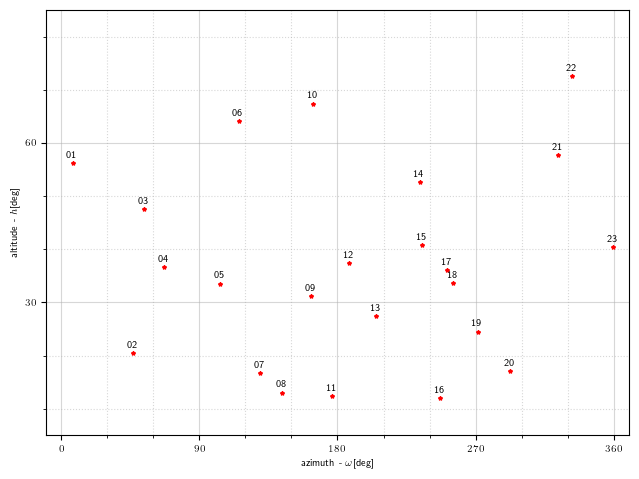

In [5]:
cd = cdata.CelestialData(pp)

date = [2021,8,5] # [yyyy, mm, dd]
time = [18,15,0]  # [HH,MM,SS] in UTC (local=UTC+1; po 27/03 =UTC+2)

# Primer
fi = [41,0,'N']
la = [20,30,'W']
h = 20.0

# Ajba ??
#fi = [46,0,'N']
#la = [13,30,'E']
#h = 50.0
pos = [nt.nav2dd(fi), nt.nav2dd(la), h]

obj_data = cd.get_all_celestial_objects_data(date, time, pos)

h_min = 10.0
h_max = 80.0
vis_objs = findVisibleObjects(obj_data, h_min, h_max)
vis_objs.sort(key=lambda k : k['az'])

i = 1
data = []
for obj in vis_objs:
    print('{:02d} - {:11s}  h = {:s}  {:s} = {:s}'.format(i,obj['name'],nt.prettyPrintAlt(obj['alt']), nt.u_omega, nt.prettyPrintAz(obj['az'])))
    data.append([obj['az'],obj['alt']])
    i += 1
    
data = np.array(data)

fig, ax = mpl.subplots()
i = 1
for da in data:
    ax.plot(da[0], da[1], marker='*', markersize=3, color='red')
    ax.text(da[0]-4, da[1]+1, '{:02d}'.format(i))
    i += 1
 
# Set proper grid
major_ticks_x = np.arange(0, 361, 90)
minor_ticks_x = np.arange(0, 361, 30)
major_ticks_y = np.arange(0, 91, 30)
minor_ticks_y = np.arange(0, 91, 10)

ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)

# And a corresponding grid
# ax.grid(which='both')
# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.5, linestyle=':')
ax.grid(which='major', alpha=0.5)

ax.set_xlabel('azimuth - $\omega$[deg]')
ax.set_ylabel('altitude - $h$[deg]')
ax.set_xlim([-10, 370])
ax.set_ylim([h_min-5, h_max+5])
fig.tight_layout()
fig.savefig('visible_stars.pdf')

In [6]:
# generate latex document
t = date + time
gha_a = cd.get_aries_gha(t)

check_latex = sp.run(['which','xelatex'])

if check_latex.returncode == 0:
    generateLatexInput(date,time,[fi,la],vis_objs,gha_a,h,h_min,h_max)
    os.system("rm -rf body.tex visible_stars.pdf *.aux *.out *.log")
else:
    print()
    print('WARNING: No LaTeX system present on this server!')

/bin/xelatex
